In [1]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

In [6]:
df_train_labels = pd.read_csv("Dataset/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

# a given patient Id may have multiple bounding boxes since he can have several opaque areas in lung
df_train_labels.iloc[0]

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object

In [8]:
patientId0 = df_train_labels["patientId"][0]
dcm_file = "Dataset/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm" % patientId0
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [10]:
img = dcm_data.pixel_array
print(type(img))
print(img.shape)
print(img.dtype)

<class 'numpy.ndarray'>
(1024, 1024)
uint8


(-0.5, 1023.5, 1023.5, -0.5)

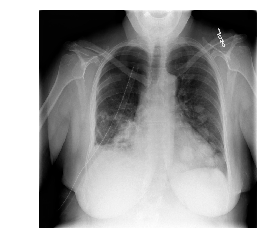

In [15]:
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis("off")

In [18]:
def parse_labels(df):
    extract_box = lambda row: [row['x'], row['y'], row['width'], row['height']]
    parsed = dict()
    
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': "Dataset/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm" % pid,
                'pneumonia': row['Target'],
                'boxes': []
            }
        
        # if the pneumonia exits, add it to the boxes with corresponding patientId 
        if row['Target'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
    
    return parsed


In [21]:
parsed_df_train = parse_labels(df_train_labels)

In [23]:
print(parsed_df_train['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': 'Dataset/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'pneumonia': 1, 'boxes': [[264.0, 152.0, 213.0, 379.0], [562.0, 152.0, 256.0, 453.0]]}


In [27]:
# visualize boxes / overlay bounding boxes on dicom image
def draw(data):
    dat = pydicom.read_file(data['dicom'])
    img = dat.pixel_array
    
    img = np.stack([img] * 3, axis=2)
    for box in data["boxes"]:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        img = overlay_box(img = img, rgb = rgb, box = box, stroke = 7)
    
    pylab.imshow(img, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

    
def overlay_box(img, rgb, box, stroke = 1):
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    x1, y1, width, height = box
    x2 = x1 + width
    y2 = y1 + height
    
    img[y1:y1 + stroke, x1:x2] = rgb
    img[y2:y2 + stroke, x1:x2] = rgb
    img[y1:y2, x1:x1 + stroke] = rgb
    img[y1:y2, x2:x2 + stroke] = rgb

    return img

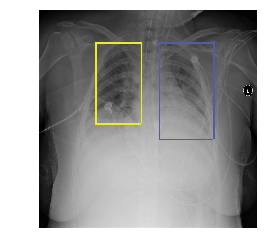

In [28]:
draw(parsed_df_train['00436515-870c-4b36-a041-de91049b9ab4'])